In [1]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from pathlib import Path

import torch.optim as optim
import pandas as pd
import torch.nn as nn
import torch

from data_loader import BraTSDataset
from unet_simple import Unet
from training_utils import train_step

# Unet modification

1. Sum as aggregator
2. Upsample in `forward`

https://arxiv.org/abs/1505.04597

<!-- ![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png) -->

## Train model

In [2]:
 # '/home/anvar/work/data/brats_slices/'
data_folder = Path('/nmnt/media/home/anvar/anvar/data/BraTS2020/brats_slices')
df = pd.read_csv(data_folder / 'meta.csv', index_col=0)
df['relative_path'] = df['relative_path'] + '.gz'
dataset = BraTSDataset(df, data_folder, nonzero_mask=True)

dataset_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=100, shuffle=True,
                                             num_workers=8)

In [3]:
device = ("cuda" if torch.cuda.is_available() else 'cpu')
model = Unet().to(device)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [4]:
for epoch in range(5):
    epoch_loss = 0
    for X_batch, y_batch in tqdm(dataset_loader):

        loss = train_step(X_batch, y_batch, model, criterion, optimizer)
        
        epoch_loss += loss     

    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(dataset_loader):.5f}')


Epoch 000: | Loss: 0.46684



Epoch 001: | Loss: 0.07152



Epoch 002: | Loss: 0.06998



Epoch 003: | Loss: 0.06885



Epoch 004: | Loss: 0.06724


## Save model parameters

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [4]:
# torch.save(model.state_dict(), './unet.pth')

## Validate model's quality

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [5]:
_ = model.load_state_dict(torch.load('./unet.pth'))

In [6]:
_ = model.eval()

In [7]:
x, y = dataset[1700]

In [8]:
y_pred = np.exp(model(x.reshape(1,1,240,240).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1

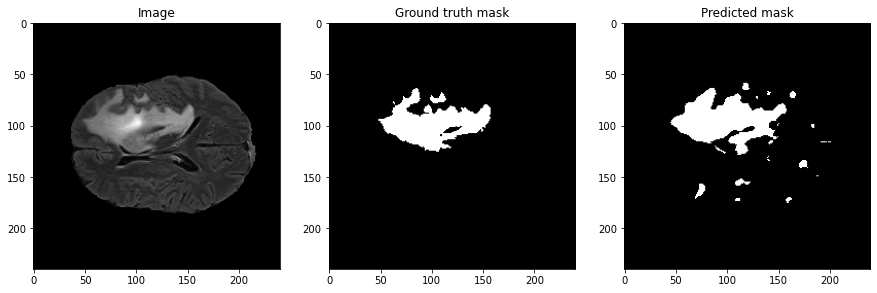

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[0, ...], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[0, ...], cmap='gray')
ax[1].set_title('Ground truth mask')
ax[2].imshow(y_pred[0, ...], cmap='gray')
ax[2].set_title('Predicted mask');

## Slice-wise dice

In [11]:
from dpipe.im.metrics import dice_score

In [18]:
dice = []
for i in tqdm(range(len(dataset))):
    x, y = dataset[i]
    y = y.detach().numpy().astype(bool)
    y_pred = np.exp(model(x.reshape(1,1,240,240).to('cuda'))[0].to('cpu').detach().numpy()) > 0.1
    dice.append(dice_score(y, y_pred))

In [19]:
np.mean(dice), np.std(dice)

(0.3922353513013597, 0.25718191180698646)

# TODO

1. Compute patient-wise DICE score
2. Do cross-validation and compute DICE score on test set
3. Train larger model longer and achieve atleast 0.5 DICE score on test set